In [8]:
%matplotlib inline
import sys
import matplotlib
import matplotlib.pyplot as plt
import glob, os
import numpy as np
from numpy.polynomial import polynomial as P
import re, csv
import pandas as pd
from math import sqrt
import seaborn as sns
from numpy.polynomial import polynomial as P
from scipy import stats
from scipy.stats import linregress
sns.set_style("whitegrid")
from IPython.display import Markdown, display, Audio
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [33]:
# Load Voimooo python wrapper
sys.path.insert(0, os.path.abspath('../../../pyvoimooo/'))
import pyvoimooo as vmo
vmo.__version__

INFO: Wav write/read: Using libsndfile in Voimooo


'0.17.6'

In [9]:
sys.path.insert(0, os.path.abspath('../../../cleese'))
import cleese 

# Analyse de données revcor SMILE
Données patients 2020 recueillies par Stéphanie Miny (CNAM)\
Données contrôles 2017 recueillies par Emmanuel Ponsot, Pablo Arias & JJ Aucouturier (CNRS)\
Données Tours 2021 recueillies par Marie Gomot. 

## Data organization

In [24]:
datasets = [{'type':'patients','exp':'miny'},
            {'type':'controls','exp':'ponsot'},
           {'type':'tours','exp':'gomot'}]

data = pd.DataFrame()

for dataset in datasets: 
    result_dir = 'data/'+dataset['type']+'/'
    result_files = glob.glob(result_dir+"results_subj*.csv")
    results = pd.DataFrame()
    for result_file in result_files: 
        #print(result_file)
        participant_results = pd.read_csv(result_file, sep = ',', decimal='.', header='infer')
        results = results.append(participant_results, ignore_index=True)
    results['type'] = dataset['type']
    results['experimentateur'] = dataset['exp']
    data = data.append(results, ignore_index=True)

In [25]:
data[data.type=='tours'].groupby(['subj']).trial.nunique()

subj
1    307
2    307
3    307
4    307
5    307
6    307
7    307
8    307
Name: trial, dtype: int64

In [50]:
# analyse only data from Tours
data = data[data.type=='tours']

## Compute order-1 kernels

In [51]:
# remove practice trials
data = data[data.block > 0]

In [136]:
# first-order kernel computed for each subject as the
# mean(filter gains of voices classified as smiling) - (mean filter gains of voices classified as non-smiling)

filter_mean_gain = data.groupby(['type','subj','session','filter_freq','response'])['filter_gain'].mean().reset_index()
positives = filter_mean_gain.loc[filter_mean_gain['response'] == 1].reset_index()
negatives = filter_mean_gain.loc[filter_mean_gain['response'] == 0].reset_index()
kernels = pd.merge(positives, negatives, on=['subj','type','session','filter_freq'])
kernels['kernel_gain'] = kernels['filter_gain_x'] - kernels['filter_gain_y']

# Kernels are then normalized for each participant by dividing them 
# by the square root of the sum of their squared values.
kernels['square_gain'] = kernels['kernel_gain']**2
for_norm = kernels.groupby(['subj','session','type'])['square_gain'].mean().reset_index()
kernels = pd.merge(kernels, for_norm, on=['subj','type','session'])
kernels['norm_gain'] = kernels['kernel_gain']/np.sqrt(kernels['square_gain_y'])

kernels.drop(columns=['index_x','response_x','filter_gain_x',
                      'index_y','response_y','filter_gain_y',
                      'square_gain_x', 'square_gain_y'], inplace=True)

In [137]:
# analyse only data from Tours
kernels = kernels[kernels.type=='tours']
# drop session, as Tours has only one
kernels.drop(columns=['session'],
            inplace=True)

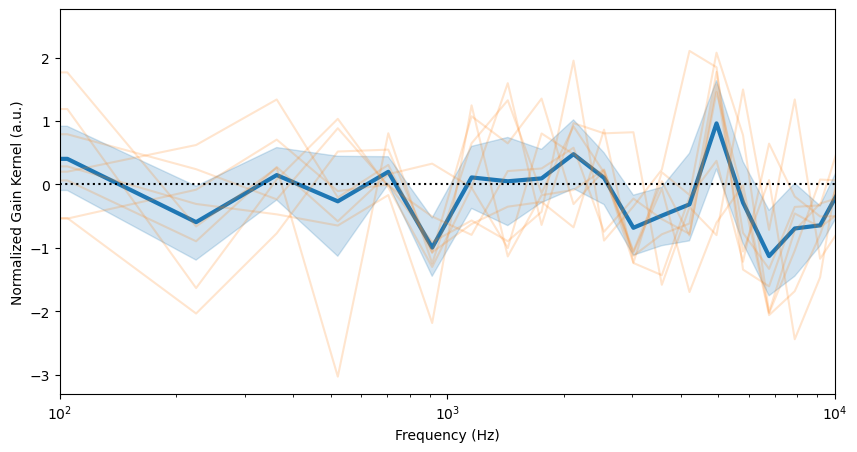

In [138]:
fig,ax = plt.subplots(figsize=(10,5))

crop_x = 10000
# display kernels 
sns.lineplot(x="filter_freq",
             y="norm_gain",
             data=kernels,
             ci=95, 
             ax=ax, lw=3)
sns.lineplot(x="filter_freq",
             y="norm_gain",
             data=kernels,
             units='subj',
             estimator=None,
             ci=95, 
             ax=ax, 
             alpha=0.2)
ax.set_xlabel("Frequency (Hz)")
#ax.legend(loc='upper left')
ax.set_ylabel("Normalized Gain Kernel (a.u.)")
ax.plot([0,crop_x],[0,0],color='k',linestyle = ':')
#ax.set_title(title)
plt.xscale('log')
ax.set_xlim([100,crop_x]);

In [144]:
# statistiques: one-sample t-test to 0 at each filter frequency

import pingouin as pg

freqs = list(kernels[kernels.filter_freq<10000].filter_freq.unique())
alpha=0.05

for freq in freqs: 
    
    gains = list(kernels[kernels.filter_freq==freq].norm_gain)
    stats = pg.ttest(gains,0)
    print("%d Hz: t(%d) = %6.3f, p = %6.4f" %(freq,stats['T'],stats['dof'],stats['p-val']), end='')
    if (stats.loc['T-test','p-val']<alpha):
        print(' (*) ')
    else:
        print()

0 Hz: t(0) =  7.000, p = 0.6707
104 Hz: t(1) =  7.000, p = 0.2007
224 Hz: t(-1) =  7.000, p = 0.1061
362 Hz: t(0) =  7.000, p = 0.5541
521 Hz: t(0) =  7.000, p = 0.5752
704 Hz: t(1) =  7.000, p = 0.1381
914 Hz: t(-3) =  7.000, p = 0.0056 (*) 
1155 Hz: t(0) =  7.000, p = 0.7064
1432 Hz: t(0) =  7.000, p = 0.8999
1751 Hz: t(0) =  7.000, p = 0.7042
2117 Hz: t(1) =  7.000, p = 0.1509
2538 Hz: t(0) =  7.000, p = 0.6602
3022 Hz: t(-2) =  7.000, p = 0.0322 (*) 
3578 Hz: t(-1) =  7.000, p = 0.0940
4217 Hz: t(0) =  7.000, p = 0.4419
4952 Hz: t(2) =  7.000, p = 0.0494 (*) 
5796 Hz: t(0) =  7.000, p = 0.4497
6767 Hz: t(-3) =  7.000, p = 0.0174 (*) 
7883 Hz: t(-1) =  7.000, p = 0.1215
9165 Hz: t(-3) =  7.000, p = 0.0079 (*) 


## Synthesize sound effect of kernel

In [127]:
def apply_kernel(wave_in, sr, filter_freq, filter_gain, gain):
        
    # create bpf
    num_channel = len(filter_freq)
    bpf = np.zeros((1,2+2*num_channel))
    bpf_val = []
    for f,g in zip(filter_freq,filter_gain): 
        bpf_val += f, np.exp(gain*g)
    #bpf_val += sr/2, 1
    bpf_val = np.array([0, 25] + bpf_val)
    bpf[0,:] = bpf_val
    
    # process with cleese
    config_file = "random_eq_profile.py"
    wav_out,bpf_out = cleese.process(soundData=wave_in, configFile=config_file, sr=sr, BPF=bpf)
    
    return wav_out, bpf_out

In [128]:
from IPython.display import Markdown, display, Audio
input_file = 'sounds/gomot_a.wav'
wave_in,sr =  vmo.readwav(input_file)

print("son de base")
Audio(data=wave_in, rate=sr)

gain = 1

print("souriant groupe")
kernel_tours = kernels.groupby(['filter_freq']).norm_gain.mean().reset_index()
wave_out, bpf_out = apply_kernel(wave_in, sr, 
                                 kernel_tours.filter_freq, 
                                 kernel_tours.norm_gain, 
                                 gain)
Audio(data=wave_out, rate=sr)
# save audio
output_file = os.path.splitext(input_file)[0]+'_smile_tours.wav'
vmo.writewav(output_file, sr, wave_out)
# save config (warning bpf_out are np.exp(gain), so np.log them back to db)
config_file = os.path.splitext(output_file)[0]+'.txt'
info = [[x,y] for x,y in zip(bpf_out[0][2::2],np.log(bpf_out[0][3::2]))]
with open(config_file,'w+',newline='') as file:
    writer = csv.writer(file);
    for row in info:
        _=writer.writerow(row)

print("anti-souriant groupe")
wave_out, bpf_out = apply_kernel(wave_in, sr, 
                                 kernel_tours.filter_freq,
                                 -kernel_tours.norm_gain, 
                                 gain)
Audio(data=wave_out, rate=sr)
# save audio
output_file = os.path.splitext(input_file)[0]+'_antismile_tours.wav'
vmo.writewav(output_file, sr, wave_out)
# save config (warning bpf_out are np.exp(gain), so np.log them back to db)
config_file = os.path.splitext(output_file)[0]+'.txt'
info = [[x,y] for x,y in zip(bpf_out[0][2::2],np.log(bpf_out[0][3::2]))]
with open(config_file,'w+',newline='') as file:
    writer = csv.writer(file);
    for row in info:
        _=writer.writerow(row)
        

son de base


souriant groupe


anti-souriant groupe


## Visualize effect on spectral envelopes (requires voimoo)

We use the vmo smile transformation to extract spectral envelopes

In [90]:
def spectral_env(wave_in, sr): 
    # extract mean spectral envelope from wave_file using the vmo smile transform
    syn, tts, f0s, envs_ori, envs_new  = vmo.smile(wave_in,sr, alpha=1.)
    env = np.mean(envs_ori,0)
    f = np.linspace(0,sr/2,len(env))
    return f,env 

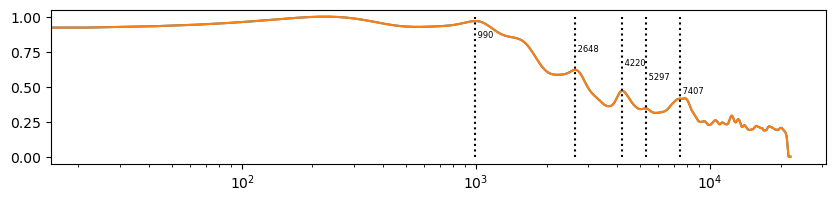

In [119]:
# extract base envelope
input_file = 'sounds/gomot_a.wav'
wave_in,sr =  vmo.readwav(input_file)
base_f, base_env = spectral_env(wave_in,sr)
# normalize amplitude & log
base_env = np.log(base_env)
base_env = (base_env - np.min(base_env))
base_env = (base_env / np.max(base_env))
fig,ax = plt.subplots(figsize=(10,2))
_=plt.plot(base_f, base_env);
plt.xscale('log');

# extract formants
from scipy.signal import argrelextrema
peaks = base_f[argrelextrema(base_env,
                             np.greater)]
base_formants = peaks[(500<peaks) & (peaks<10000)]
base_formants = base_formants[[0,1,2,3,4]]

_=plt.plot(base_f, base_env);
plt.xscale('log')
for id,formant in enumerate(base_formants):
    _=plt.plot([formant,formant],[0, 1], 'k:');
    _=plt.text(formant,0.85-id*0.1,
               s=' %d'%formant,
               size=6,
               ha='left')
    #print(formant)

In [129]:
def display_kernel_enveloppe(kernels_df,title, ax1):
    
    crop_x = 10000 # Hz
    enveloppe_gain = 5
    
    # display kernels (patients and controls)
    sns.lineplot(x="filter_freq",
             y="norm_gain",
             data=kernels,
             ci=95, ax=ax1)
    ax1.set_xlabel("Frequency (Hz)")
    #ax1.legend(loc='upper left')
    ax1.set_ylabel("Normalized Gain Kernel (a.u.)")
    ax1.plot([0,crop_x],[0,0],color='k',linestyle = ':')
    ax1.set_title(title)
    plt.xscale('log')
    ax1.set_xlim([100,crop_x])

    # display base enveloppe
    plt.plot(base_f, enveloppe_gain**base_env,'k')
    
    # display base formants 
    for index, formant in enumerate(base_formants):
        plt.plot([formant,formant],[0, enveloppe_gain-1], 'k:')
        plt.text(formant, enveloppe_gain-0.9, 'F'+str(index+1), horizontalalignment = 'center')

    # display enveloppe of sound filtered by kernel
    group_kernel = kernels.groupby('filter_freq')['norm_gain'].mean().reset_index()
    filter_freq = list(group_kernel.filter_freq)
    filter_gain = list(group_kernel.norm_gain)
        
    wave_out, bpf_out = apply_kernel(wave_in = wave_in,
                                 sr=sr,
                                 filter_freq=filter_freq,
                                 filter_gain=filter_gain, 
                                 gain=1.5)
    f_out,env_out = spectral_env(wave_out,sr)
    env_out = np.log(env_out)
    env_out = (env_out - np.min(env_out))
    env_out = (env_out / np.max(env_out))
    plt.plot(f_out, enveloppe_gain**env_out,color='b');



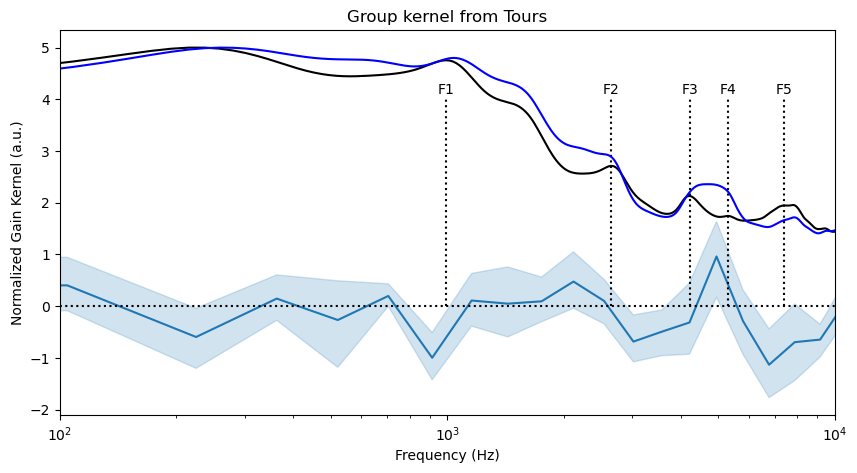

In [130]:
fig,ax = plt.subplots(figsize=(10,5))
plt.style.use('default')
display_kernel_enveloppe(kernels,'Group kernel from Tours',ax)

In [131]:
def visualize_kernel(wave_in, sr, filter_freq, filter_gain, ax1, gain_range):
    
    # apply kernel with several gains, and store in dataframe
    #gain_range = np.arange(2,-0.5,-0.1)
    freqs = []
    amps = []
    gains = []
    for gain in gain_range:
        wave_out, bpf_out = apply_kernel(wave_in = wave_in,
                                         sr=sr,
                                         filter_freq=filter_freq, 
                                         filter_gain=filter_gain,
                                         gain=gain)
    
        f_out,env_out = spectral_env(wave_out,sr)
        freqs+=list(f_out)
        amps+=[np.log(g) for g in list(env_out)]
        gains+=len(f_out)*[gain]
        
    data = pd.DataFrame.from_dict({'f':freqs, 'amp':amps, 'gain':gains})
    
    # plot
    sns.lineplot(data=data, 
            x='f',
            y='amp',
            hue='Gain ' + data['gain'].astype(str), 
            palette="RdBu", 
            ax=ax1)
    _=plt.xscale('log')
    #_=plt.xlim([400, 2000])
    #_=plt.ylim([-10,-2])
    _=plt.legend('',frameon=False)

    # plot original env
    f_in, env_in = spectral_env(wave_in,sr)
    _=plt.plot(f_in,[np.log(g) for g in list(env_in)], 'k')

Text(0.5, 0, 'Freq (Hz)')

Text(0, 0.5, 'Power (a.u)')

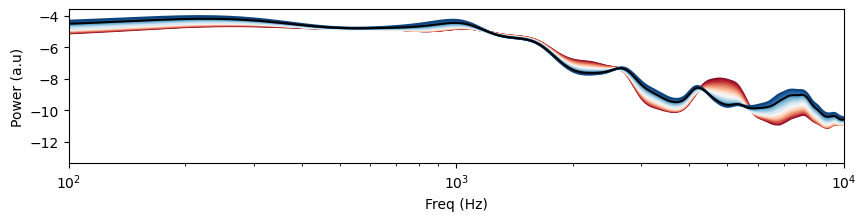

In [147]:
# figure JASA
fig = plt.figure(figsize=(10,2))
ax = fig.add_subplot(1,1,1)
control_kernels = kernels.groupby('filter_freq')['norm_gain'].mean().reset_index()
visualize_kernel(wave_in, sr, 
                 list(control_kernels.filter_freq), 
                 list(control_kernels.norm_gain), 
                 ax, np.arange(2,-0.5,-0.1))
_=plt.xlim([100, 10000])
plt.xlabel('Freq (Hz)')
plt.ylabel('Power (a.u)')